# Importing Necessaary Libraries

In [ ]:
import torch
import os

In [ ]:
from google.colab import userdata

# Importing Dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("hanesh007/mtsample")
dataset

DatasetDict({
    train: Dataset({
        features: ['Question', 'Options', 'Answer'],
        num_rows: 50
    })
})

In [ ]:
!pip3 install -q -U bitsandbytes==0.42.0
!pip3 install -q -U peft==0.8.2
!pip3 install -q -U trl==0.7.10
!pip3 install -q -U accelerate==0.27.1
!pip3 install -q -U datasets==2.17.0



In [ ]:
!pip install -q -U git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

# Genrating  Responses Before Fine Tuning

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, GemmaTokenizer

model_id = "google/gemma-7b"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id, token=os.environ['HF_TOKEN'])
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0}, token=os.environ['HF_TOKEN'])
for example in dataset['train']:
    question = example['Question']
    options = example['Options']
    prompt = f"For the question: {question} from the options: {options} choose the answer from options and provide only it"
    input_ids = tokenizer(prompt, return_tensors='pt').to("cuda")
    output = model.generate(**input_ids, max_length=100, temperature=0.7, num_return_sequences=1,)
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    print("For the question:", question)
    print(response)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


For the question: What is the largest organ in the human body?
For the question: What is the largest organ in the human body? from the options: a) Liver, b) Skin, c) Heart, d) Brain choose the answer from options and provide only it.

Answer:

Step 1/2
The largest organ in the human body is the skin.

Step 2/2
Therefore, the answer is b) Skin.


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


For the question: Which organ produces insulin in the human body?
For the question: Which organ produces insulin in the human body? from the options: a) Pancreas, b) Liver, c) Kidney, d) Gallbladder choose the answer from options and provide only it.

Answer:

Step 1/2
The pancreas is the organ that produces insulin in the human body.

Step 2/2
Therefore, the correct answer is a) Pancreas.
For the question: What is the unit of measurement for blood pressure?
For the question: What is the unit of measurement for blood pressure? from the options: a) Liters, b) Pounds, c) Milligrams, d) Millimeters choose the answer from options and provide only it.

Answer:

Step 1/2
Blood pressure is measured in millimeters of mercury (mmHg) or kilopascals (kPa).

Step 2/2
Therefore, the correct answer is d) Millimeters.
For the question: Which blood type is considered the universal donor?
For the question: Which blood type is considered the universal donor? from the options: a) A, b) B, c) AB, d) O cho

# Performance Report

# Before Fine Tuning

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, precision_score
accuracy = accuracy_score(original_labels, before_pred)
f1 = f1_score(original_labels, before_pred, average='weighted')
precision = precision_score(original_labels, before_pred, average='weighted',zero_division=1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)

Accuracy: 0.54
Precision: 1.0
F1 Score: 0.54


In [ ]:
predicted_answers=[]

# FineTuning the Model Using SFTTrainer

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, GemmaTokenizer
model_id = "google/gemma-7b"
tokenizer = AutoTokenizer.from_pretrained(model_id, token=os.environ['HF_TOKEN'])
model = AutoModelForCausalLM.from_pretrained(model_id, token=os.environ['HF_TOKEN'])

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from datasets import load_dataset
data = load_dataset("hanesh007/mtdataset_exp")
data

DatasetDict({
    train: Dataset({
        features: ['Question', 'Options', 'Answer', 'Reason'],
        num_rows: 50
    })
})

In [ ]:
import transformers
from trl import SFTTrainer
def formatting_func(example):
    text = f"Question: {example['Question'][0]}\nReason: {example['Reason'][0]}"
    return [text]
trainer = SFTTrainer(
    model=model,
    train_dataset=data["train"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=10,
        learning_rate=2e-4,
        logging_steps=1,
        output_dir="outputs",
    ),
    formatting_func=formatting_func,
)
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:223: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:290: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


Step,Training Loss
1,0.471200
2,0.471200
3,4.959900
4,8.381400
5,16.196300
6,26.342400
7,9.208400
8,5.639000
9,4.596500
10,3.564800


TrainOutput(global_step=10, training_loss=7.983101916313172, metrics={'train_runtime': 220.3924, 'train_samples_per_second': 0.181, 'train_steps_per_second': 0.045, 'total_flos': 18602997350400.0, 'train_loss': 7.983101916313172, 'epoch': 10.0})

# Genrating  Responses After Fine Tuning

In [ ]:
for example in dataset['train']:
    question = example['Question']
    options = example['Options']
    prompt = f"For the question: {question} from the options: {options} choose the answer from options and provide only it"
    input_ids = tokenizer(prompt, return_tensors='pt').to("cuda")
    output = model.generate(**input_ids, max_length=100, temperature=0.7, num_return_sequences=1)
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    print("For the question:", question)
    print(response)

For the question: What is the largest organ in the human body?
For the question: What is the largest organ in the human body? from the options: a) Liver, b) Skin, c) Heart, d) Brain choose the answer from options and provide only it.

Answer:

Step 1/2
The largest organ in the human body is the skin.

Step 2/2
Therefore, the answer is b) Skin.
For the question: Which organ produces insulin in the human body?
For the question: Which organ produces insulin in the human body? from the options: a) Pancreas, b) Liver, c) Kidney, d) Gallbladder choose the answer from options and provide only it.

Answer:  

Step 1/2
The pancreas is the organ that produces insulin in the human body.

Step 2/2
Therefore, the correct answer is a) Pancreas.
For the question: What is the unit of measurement for blood pressure?
For the question: What is the unit of measurement for blood pressure? from the options: a) Liters, b) Pounds, c) Milligrams, d) Millimeters choose the answer from options and provide only i

# Calculating Accuracies Before and After Fine Tuning the Model


---



# Loading the Output Values Dataset

In [ ]:
from datasets import load_dataset
finalData = load_dataset("hanesh007/GemmaModelOutputs")
finalData

DatasetDict({
    train: Dataset({
        features: ['Questions', 'Orginal_Answers', 'Predicted_Answers', 'FineTuned_Predicted_Answers'],
        num_rows: 50
    })
})

In [ ]:
original_labels = finalData['train']['Orginal_Answers']
before_pred = finalData['train']['Predicted_Answers']
fine_pred = finalData['train']['FineTuned_Predicted_Answers']

## Before Fine Tuning

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, precision_score
accuracy = accuracy_score(original_labels, before_pred)
f1 = f1_score(original_labels, before_pred, average='weighted')
precision = precision_score(original_labels, before_pred, average='weighted',zero_division=1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)

Accuracy: 0.54
Precision: 1.0
F1 Score: 0.54


# After Fine Tuning

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, precision_score
accuracy = accuracy_score(original_labels, fine_pred)
f1 = f1_score(original_labels, fine_pred, average='weighted')
precision = precision_score(original_labels, fine_pred, average='weighted',zero_division=1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)


Accuracy: 0.72
Precision: 1.0
F1 Score: 0.72


# Comparision

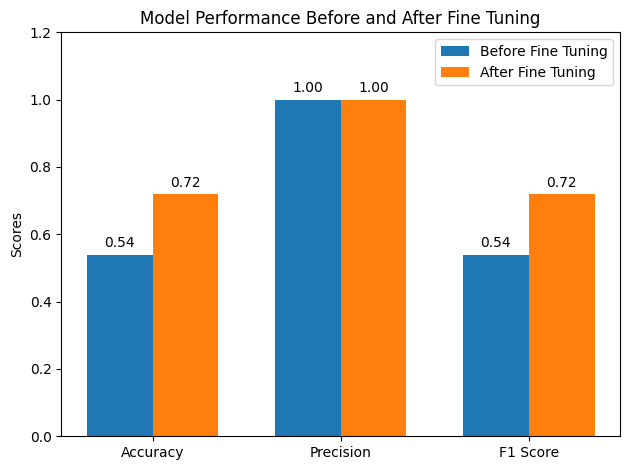

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data setup
metrics = ['Accuracy', 'Precision', 'F1 Score']
metrics_before = [0.54, 1.0, 0.54]
metrics_after = [0.72, 1.0, 0.72]
width=0.35

# Helper function to create bars and add labels
def create_bars(ax, positions, values, label, width=0.35):
    bars = ax.bar(positions, values, width, label=label)
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    return bars

# Plotting
x = np.arange(len(metrics))  # the label locations
fig, ax = plt.subplots()
create_bars(ax, x - width/2, metrics_before, 'Before Fine Tuning')
create_bars(ax, x + width/2, metrics_after, 'After Fine Tuning')

# Set labels and titles
ax.set_ylabel('Scores')
ax.set_title('Model Performance Before and After Fine Tuning')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim([0, 1.2])  # Set y-axis limit
ax.legend()

fig.tight_layout()
plt.show()
